In [1]:
import sys
sys.path.append('..')
from mtDNAsim import *
import pandas as pd
import numpy as np
from copy import deepcopy
from collections import Counter
import argparse
import phylovelo as pv

/home/wangkun/mtDNA_simulation/notebook/../mtDNAsim/sim_utils.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [29]:
import re

In [ ]:
parser = argparse.ArgumentParser(description='save file name')
parser.add_argument('-p', type=str)
parser.add_argument('-f', type=str)
filename = parser.parse_args().f
data_path = parser.parse_args().p
if data_path is None:
    data_path = "../results"

In [2]:
filename = 'linear_test'
data_path = '../results'

In [5]:
num_elements = 5
system = Gillespie(
    num_elements,
    inits=[1, 0, 0, 0, 0],
    max_cell_num=20000
)

p0 = lambda t: (1 - 1 / (1 + np.exp(-0.6 * (t - 18))))
p1 = lambda t: (1 - 1 / (1 + np.exp(-0.6 * (t - 18))))
p2 = lambda t: (1 - 1 / (1 + np.exp(-0.6 * (t - 18))))
p3 = lambda t: (1 - 1 / (1 + np.exp(-0.6 * (t - 19))))
p4 = lambda t: (1 - 1 / (1 + np.exp(-0.6 * (t - 20))))
d0 = lambda t: 1 - p0(t)
d1 = lambda t: 1 - p1(t)
d2 = lambda t: 1 - p2(t)
d3 = lambda t: 1 - p3(t)

system.add_reaction(p0, [1, 0, 0, 0, 0], [2, 0, 0, 0, 0], index=0) # 0 self renew
system.add_reaction(p1, [0, 1, 0, 0, 0], [0, 2, 0, 0, 0], index=1) # 1 self renew
system.add_reaction(p2, [0, 0, 1, 0, 0], [0, 0, 2, 0, 0], index=2) # 2 self renew
system.add_reaction(p3, [0, 0, 0, 1, 0], [0, 0, 0, 2, 0], index=3) # 3 self renew
system.add_reaction(p4, [0, 0, 0, 0, 1], [0, 0, 0, 0, 2], index=4) # 4 self renew
system.add_reaction(d0, [1, 0, 0, 0, 0], [0, 1, 0, 0, 0], index=5) # 0 -> 1 differentiation
system.add_reaction(d1, [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], index=6) # 1 -> 2 differentiation
system.add_reaction(d2, [0, 0, 1, 0, 0], [0, 0, 0, 1, 0], index=7) # 2 -> 3 differentiation
system.add_reaction(d3, [0, 0, 0, 1, 0], [0, 0, 0, 0, 1], index=8) # 3 -> 4 differentiation

system.evolute(20000000)

  0%|          | 0/20000 [00:00<?, ?it/s]

In [6]:
tree_file_name = f"tree_origin_linear_{filename}.csv"
cell_num_file_name = f"cell_num_linear_{filename}.csv"

curr_cells = []
t = np.array(system.generation_time)
cell_num_traj = np.array(system.n)

for i in system.curr_cells.values():
    curr_cells += i
# while tree_file_name in os.listdir(data_path):
#     tree_file_name = tree_file_name[:-1] + str(int(tree_file_name[-1]) + 1)


#     cell_num_file_name = cell_num_file_name[:-1] + str(int(cell_num_file_name[-1]) + 1)

np.savetxt(
    f'{data_path}/{cell_num_file_name}',
    np.hstack((t.reshape(-1, 1), cell_num_traj)),
    fmt="%.5f",
)

sim_utils.wirte_lineage_info(
    f'{data_path}/{tree_file_name}', system.anc_cells, curr_cells, system.t[-1]
)
try:
    reconstruct(f'{data_path}/tree_origin_linear_{filename}.csv', output=f'{data_path}/linear_tree_gt_{filename}.nwk', num=5000, is_balance=True)
except:
    os.system(f'rm {data_path}/{tree_file_name}')
    os.system(f'rm {data_path}/{cell_num_file_name}')

tree_file = f'{data_path}/linear_tree_gt_{filename}.nwk'
phylo_tree, branch_colors = loadtree(tree_file)
sampled_cells = [i.name for i in phylo_tree.get_terminals()]
cell_names, cell_states, cell_generation = get_annotation(f'{data_path}/tree_origin_linear_{filename}.csv')
cell_states = pd.DataFrame(data=cell_states, index=cell_names).loc[sampled_cells]
cell_generation = pd.DataFrame(data=cell_generation, index=cell_names).loc[sampled_cells].to_numpy()

sd = scData(
    phylo_tree=phylo_tree,
    cell_states=cell_states.to_numpy().T[0].astype('int'),
    cell_generation=cell_generation.T[0].astype('int'),
    cell_names=sampled_cells
)

In [7]:
ge, base_expr = sim_base_expr(sd.phylo_tree,
                                 cell_states,
                                 Ngene=4000,
                                 r_variant_gene=0.4,
                                 diff_map={0:[0],1:[0],2:[1],3:[2],4:[3]},
                                 forward_map={},
                                 mu0_loc=0,
                                 mu0_scale=1,
                                 drift_loc=0,
                                 drift_scale=0.1,
                                )

sd.count = get_count_from_base_expr(add_lineage_noise(sd.phylo_tree, base_expr), alpha=0.5)
sd.count.to_csv(f'{data_path}/count_{filename}.csv')
sd.dimensionality_reduction(method='tsne', perplexity=30)
sd.Xdr.to_csv(f'{data_path}/tsne_{filename}.csv')

seqs = DNAmutation(phylo_tree, mut_rate=1.5)
seqs = seqs.astype(int)

/home/wangkun/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/wangkun/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [13]:
def mtmutation(tree, mut_rate=1.6e-3, **params):
    '''
    Args:
        nmts (default:1000): 
            number of mts
        init_mut_rate (default:0.2): 
            initial mutation rate
        len_mtDNA (default:16569): 
            length of mtDNA seq (unable)
        birth_rate (default:1): 
            birth_rate of initial mts
        death_rate (default:0.1): 
            death_rate of initial mts
        mt_copynumber (default:2):
            copy number of mtDNA
        
    '''
    nmts = params.pop('nmts', 1000)
    init_mut_rate = params.pop('init_mut_rate', 0.2)
    len_mtDNA = params.pop('len_mtDNA', 16569)
    birth_rate = params.pop('birth_rate', 1)
    death_rate = params.pop('death_rate', 0.1)
    mt_copynumber = params.pop('mt_copynumber', 2)
    if not callable(mt_copynumber):
        mt_copynumber = lambda x: mt_copynumber
    
    # for i in range(10):
    #     try:
    init_cell_muts = initialize_mtmut(nmts, init_mut_rate, len_mtDNA, birth_rate, death_rate)
        #     break
        # except:
        #     continue
        

    global_mutid = max([max(i.union({0})) for i in init_cell_muts])
    mt_mutations = {tree.root.name:init_cell_muts}
    
    for i in tqdm(Phylo.BaseTree._preorder_traverse(tree.root, lambda elem: elem.clades), total=len(tree.get_terminals())+len(tree.get_nonterminals())):
        if not i.is_terminal():
            new_mts = cell_division_with_mt(mt_mutations[i.name], global_mutid, mut_rate, mt_copynumber(int(re.findall('(?<=<)[0-9]+', i.name)[0])))
            global_mutid = new_mts[2]
            for ind, j in enumerate(i.clades):
                mt_mutations[j.name] = new_mts[ind]
    # muts = []
    # cell_names = []
    # for i in tree.get_terminals():
    #     muts.append(mt_mutations[i.name])
    #     cell_names.append(i.name)
    return mt_mutations, global_mutid

def mut_freq(mt_muts, max_mut_id = None, sel_cells=None):
    if not max_mut_id:
        max_mut_id = np.max([np.max(list(j)) for j in mt_muts[i.name] if j for i in mt_muts])
    max_mut_id += 1
    mut_freqs = []
    cell_names = []
    for cell in tqdm(sel_cells):
        mut_pos = np.zeros((len(mt_muts[cell]), max_mut_id))
        for ind, mt in enumerate(mt_muts[cell]):
            mut_pos[ind][list(mt)] = 1
        mut_freqs.append(mut_pos.sum(0)/len(mt_muts[cell]))
        cell_names.append(cell)
    mf = pd.DataFrame(mut_freqs, index=cell_names)
    mf = mf[mf.columns[mf.sum()>0]]
    return mf

In [69]:
# early
# mt_muts, mutid = mtmutation(phylo_tree, mut_rate=0.0016, init_mut_rate=5, mt_copynumber=lambda x: 1.3 if x <= 5 else 2.2, nmts=500)
# mid
# mt_muts, mutid = mtmutation(phylo_tree, mut_rate=0.0016, init_mut_rate=5, mt_copynumber=lambda x: 1.6 if x <= 10 else 2.2, nmts=500)
# late
mt_muts, mutid = mtmutation(phylo_tree, mut_rate=0.0016, init_mut_rate=5, mt_copynumber=lambda x: 1.8 if x <= 20 else 2.4, nmts=500)

  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/25344 [00:00<?, ?it/s]

In [70]:
mt_num = []
cell_gen = []
for c in phylo_tree.get_nonterminals():
    cell_gen.append(int(re.findall('(?<=<)[0-9]+', c.name)[0]))
    mt_num.append(len(mt_muts[c.name]))

Text(0.5, 0, 'generation')

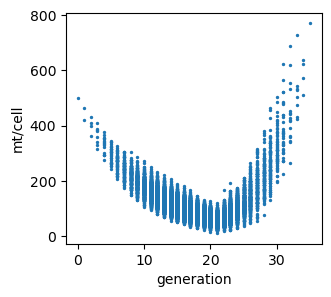

In [71]:
fig, ax = plt.subplots(figsize=(3.3,3))
ax.scatter(cell_gen, mt_num, s=2)
ax.set_ylabel('mt/cell')
ax.set_xlabel('generation')


Text(0.5, 0, 'generation')

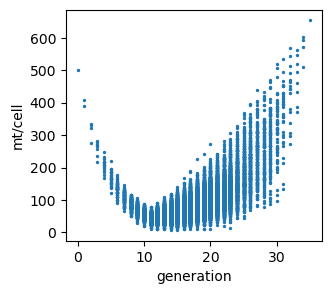

In [58]:
fig, ax = plt.subplots(figsize=(3.3,3))
ax.scatter(cell_gen, mt_num, s=2)
ax.set_ylabel('mt/cell')
ax.set_xlabel('generation')


Text(0.5, 0, 'generation')

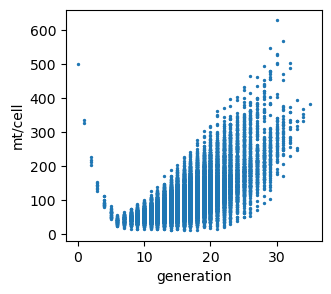

In [50]:
fig, ax = plt.subplots(figsize=(3.3,3))
ax.scatter(cell_gen, mt_num, s=2)
ax.set_ylabel('mt/cell')
ax.set_xlabel('generation')

In [15]:
# success = 0
# while not success:
#     try:
#         mt_muts, mutid = mtmutation(phylo_tree, mut_rate=0.0016, init_mut_rate=5, mt_copynumber=lambda x: 1.3 if x <= 5 else 2.5, nmts=500)
#         success = 1
#     except:
#         None

pre_existing_mut = set()
for i in mt_muts['<0_0>']:
    pre_existing_mut = pre_existing_mut.union(i)

mf = mut_freq(mt_muts, mutid, sel_cells=[i.name for i in phylo_tree.get_terminals()])
mt_seqs = mf.astype(bool).astype(int)
mt_pre = mt_seqs[mt_seqs.columns[np.isin(mt_seqs.columns, list(pre_existing_mut))]]
mt_dn =  mt_seqs[mt_seqs.columns[~np.isin(mt_seqs.columns, list(pre_existing_mut))]]
mf.to_csv(f'{data_path}/mt_mut_freq_{filename}.csv')
mf1 = deepcopy(mf)
mf1[mf1<0.01] = 0
mt1_seqs = mf1.astype(bool).astype(int)
mt1_pre = mt1_seqs[mt1_seqs.columns[np.isin(mt1_seqs.columns, list(pre_existing_mut))]]
mt1_dn =  mt1_seqs[mt1_seqs.columns[~np.isin(mt1_seqs.columns, list(pre_existing_mut))]]

mf5 = deepcopy(mf)
mf5[mf5<0.05] = 0
mt5_seqs = mf5.astype(bool).astype(int)
mt5_pre = mt5_seqs[mt5_seqs.columns[np.isin(mt5_seqs.columns, list(pre_existing_mut))]]
mt5_dn =  mt5_seqs[mt5_seqs.columns[~np.isin(mt5_seqs.columns, list(pre_existing_mut))]]

# with open(f'{data_path}/mt_mut_{filename}.phy', 'w') as f:
#     f.write('{} {}\n'.format(*mt_seqs.shape))
#     for cell in mt_seqs.index:
#         f.write('{} {}\n'.format(cell[1:-1], ''.join(mt_seqs.loc[cell].astype(str)).replace('0', 'A').replace('1', 'G')))

# with open(f'{data_path}/mt_mut_pre_{filename}.phy', 'w') as f:
#     f.write('{} {}\n'.format(*mt_pre.shape))
#     for cell in mt_pre.index:
#         f.write('{} {}\n'.format(cell[1:-1], ''.join(mt_pre.loc[cell].astype(str)).replace('0', 'A').replace('1', 'G')))
        
# with open(f'{data_path}/mt_mut_dn_{filename}.phy', 'w') as f:
#     f.write('{} {}\n'.format(*mt_dn.shape))
#     for cell in mt_dn.index:
#         f.write('{} {}\n'.format(cell[1:-1], ''.join(mt_dn.loc[cell].astype(str)).replace('0', 'A').replace('1', 'G')))  
        
# with open(f'{data_path}/mt1_mut_{filename}.phy', 'w') as f:
#     f.write('{} {}\n'.format(*mt1_seqs.shape))
#     for cell in mt1_seqs.index:
#         f.write('{} {}\n'.format(cell[1:-1], ''.join(mt1_seqs.loc[cell].astype(str)).replace('0', 'A').replace('1', 'G')))
        
# with open(f'{data_path}/mt1_mut_pre_{filename}.phy', 'w') as f:
#     f.write('{} {}\n'.format(*mt1_pre.shape))
#     for cell in mt1_pre.index:
#         f.write('{} {}\n'.format(cell[1:-1], ''.join(mt1_pre.loc[cell].astype(str)).replace('0', 'A').replace('1', 'G')))
        
# with open(f'{data_path}/mt1_mut_dn_{filename}.phy', 'w') as f:
#     f.write('{} {}\n'.format(*mt1_dn.shape))
#     for cell in mt1_dn.index:
#         f.write('{} {}\n'.format(cell[1:-1], ''.join(mt1_dn.loc[cell].astype(str)).replace('0', 'A').replace('1', 'G')))    

# with open(f'{data_path}/mt5_mut_{filename}.phy', 'w') as f:
#     f.write('{} {}\n'.format(*mt5_seqs.shape))
#     for cell in mt5_seqs.index:
#         f.write('{} {}\n'.format(cell[1:-1], ''.join(mt5_seqs.loc[cell].astype(str)).replace('0', 'A').replace('1', 'G')))
        
# with open(f'{data_path}/mt5_mut_pre_{filename}.phy', 'w') as f:
#     f.write('{} {}\n'.format(*mt_pre.shape))
#     for cell in mt5_pre.index:
#         f.write('{} {}\n'.format(cell[1:-1], ''.join(mt5_pre.loc[cell].astype(str)).replace('0', 'A').replace('1', 'G')))
        
# with open(f'{data_path}/mt5_mut_dn_{filename}.phy', 'w') as f:
#     f.write('{} {}\n'.format(*mt_dn.shape))
#     for cell in mt5_dn.index:
#         f.write('{} {}\n'.format(cell[1:-1], ''.join(mt5_dn.loc[cell].astype(str)).replace('0', 'A').replace('1', 'G')))     

# with open(f'{data_path}/dna_mut_{filename}.phy', 'w') as f:
#     f.write('{} {}\n'.format(*seqs.shape))
#     for cell in seqs.index:
#         f.write('{} {}\n'.format(cell[1:-1], ''.join(seqs.loc[cell].astype(str)).replace('0', 'A').replace('1', 'G')))
        

  0%|          | 0/5000 [00:00<?, ?it/s]